# boxplots
This page contains instructions and documentation for creating plots used to visualize curve ensembles. 

## spaghetti_plot
Plots a random selection of curves. 

### Parameters
`client` (`bigquery.Client`): BigQuery client object.

`table_name` (`str`): BigQuery table name containing data in 'dataset.table' form. 

`reference_table` (`str`): BigQuery table name containing reference table in 'dataset.table' form.

`geo_level` (`str`): The name of a column from the reference table. The geographical level used to determine what places are included. 

`geo_values` (`str` or `listlike` or `None`): The source(s) to be included. A value or subset of values from the `geo_level` column. If None, then all values will be included. 

`geo_column` (`str`, optional): Name of column in original table containing geography identifier. Defaults to 'basin_id'.

`reference_column` (`str`, optional): Name of column in original table containing the geography corresponding to data in `source_column` and `target_column`. Defaults to 'basin_id'. 

`value` (`str`, optional): Name of column in the original table containing the importation value to be analyzed. Defaults to 'value'.

`n` (`int`, optional): Number of curves to plot. Defaults to 25. 

---
### Returns
`fig` (`plotly.graph_objects.Figure`): Plotly Figure containing visualization. 

---

### Example

In [13]:
import epidemic_intelligence as ei
from google.oauth2 import service_account
from google.cloud import bigquery

credentials = service_account.Credentials.from_service_account_file('../../../credentials.json') # use the path to your credentials
project = 'net-data-viz-handbook' # use your project name
# Initialize a GC client
client = bigquery.Client(credentials=credentials, project=project)

table_name = 'h1n1_R2.basins_prevalence_agg'
reference_table = 'reference.gleam-geo-map'
reference_column = 'basin_id' # name of a column in reference table
geo_column = 'basin_id' # name of a column in table corresponding to column in reference table
geo_level = 'basin_label' 
geo_values = 'Portland(US-ME)' 
value = 'Infectious_18_23'

sp_fig = ei.spaghetti_plot(
    client=client,
    table_name=table_name,
    reference_table=reference_table,
    geo_level=geo_level,
    geo_values=geo_values,
    geo_column=geo_column,
    reference_column=reference_column,
    value=value,
    n=100)

# finishing touches
sp_fig.update_layout(width=900, height=500, 
                     showlegend=True, 
                     font_family='PT Sans Narrow', 
                     title='Spaghetti Plot',)
sp_fig.show()

In [14]:
datasets = list(client.list_datasets())
project = client.project

if datasets:
    print("Datasets in project {}:".format(project))
    for dataset in datasets:
        print("\t{}".format(dataset.dataset_id))
else:
    print("{} project does not contain any datasets.".format(project))

Datasets in project net-data-viz-handbook:
	eli
	h1n1_R2
	importation_data
	reference
	sri_data


## functional_boxplot

A functional boxplot uses curve-based statistics that treat entire curves as a single data point, as opposed to each observation in a curve. Always plots the median and interquartile range. 

### Parameters
`client` (`bigquery.Client`): BigQuery client object.

`table_name` (`str`): BigQuery table name containing data in 'dataset.table' form. 

`reference_table` (`str`): BigQuery table name containing reference table in 'dataset.table' form.

`geo_level` (`str`): The name of a column from the reference table. The geographical level used to determine what places are included. 

`geo_values` (`str` or `listlike` or `None`): The source(s) to be included. A value or subset of values from the `geo_level` column. If None, then all values will be included. 

`geo_column` (`str`, optional): Name of column in original table containing geography identifier. Defaults to 'basin_id'.

`reference_column` (`str`, optional): Name of column in original table containing the geography corresponding to data in `source_column` and `target_column`. Defaults to 'basin_id'. 

`value` (`str`, optional): Name of column in the original table containing the importation value to be analyzed. Defaults to 'value'.

`num_clusters` (`int`, optional): Number of clusters that curves will be broken into based on `grouping_method`. Defaults to 1. *Note: raising `num_clusters` above one significantly increases runtime.*

`num_features` (`int`, optional): Number of features the kmeans algorithm will use to group curves if `num_clusters` in greater than 1. Must be less than or equal to number of run_ids in table. 

`grouping_method` (`str`, optional): Method used to group curves. Must be one of: 
- `'mse'` *(default)*: Fixed-time pairwise mean squared error between curves.

- `'abc'`: Fixed-time pairwise area between curves. Also called mean absolute error.  

`kmeans_table` (`str`, optional): BigQuery table name containing clustering information in 'dataset.table' form. Used when kmeans has already been performed with `delete_data=False`. Allows function to skip costly kmeans algorithm. 

`centrality_method` (`str`, optional): Method used to determine curve centrality within their group. Must be one of:

- `'mse'` *(default)*: Summed fixed-time mean squared error between curves.

- `'abc'`: Summed fixed-time pairwise area between curves. Also called mean absolute error.

- `'mbd'`: Modified band depth. For more information, see [Sun and Genton (2011)](https://www.tandfonline.com/doi/abs/10.1198/jcgs.2011.09224).

`threshold` (`float`, optional): Number of interquantile ranges from median curve must be to not be considered an outlier. Defaults to 1.5. 

`dataset` (`str` or `None`, optional): Name of BigQuery dataset to store intermediate tables. If `None`, then random hash value will be used. Defaults to `None`. 

`delete_data` (`bool`, optional): If True, then intermediate data tables will not be deleted. Defaults to False. 

`overwrite` (`bool`, optional): If True, then will not prompt for confirmation if overwriting an existing BigQuery dataset. Defaults to False. 

---
### Returns
`fig` (`plotly.graph_objects.Figure`): Plotly Figure containing visualization. 

---

### Example

In [19]:
# required
table_name = 'h1n1_R2.basins_prevalence_agg'
reference_table = 'reference.gleam-geo-map'
reference_column = 'basin_id' # name of a column in reference table
geo_column = 'basin_id' # name of a column in table corresponding to column in reference table
geo_level = 'basin_label'
geo_values = 'Portland(US-ME)'
value = 'Infectious_18_23'

# Set parameters for grouping
num_clusters = 1
num_features = 20 
grouping_method = 'mse' # mean squared error
centrality_method = 'mse' # mean squared error

dataset = None
delete_data = True

fbp_fig = ei.functional_boxplot(
    client=client,
    table_name=table_name,
    reference_table=reference_table,
    geo_level=geo_level,
    geo_values=geo_values,
    geo_column=geo_column,
    reference_column=reference_column,
    value=value,
    num_clusters=num_clusters,
    num_features=num_features,
    grouping_method=grouping_method,
    centrality_method=centrality_method,
    dataset=dataset,
    delete_data=delete_data,
    overwrite=True
)

# finishing touches
fbp_fig.update_layout(width=900, height=500, 
                     showlegend=True, 
                     font_family='PT Sans Narrow', 
                     title='Functional Boxplot',
                     yaxis_title="Infectious 18-23yo"
)
fbp_fig.show()

Dataset `net-data-viz-handbook.2960953819c18aefde35e2664e037e202852ffcee5c018a1f90287fae11d3b14` created.
BigQuery dataset `net-data-viz-handbook.2960953819c18aefde35e2664e037e202852ffcee5c018a1f90287fae11d3b14` removed successfully, or it did not exist.


## fixed_time_boxplot

A fixted-time boxplot uses fixed-time statistics that rank each point at each time step, and use those to construct confidence intervals for each time step. Always plots the median and interquartile range. 

### Parameters
`client` (`bigquery.Client`): BigQuery client object.

`table_name` (`str`): BigQuery table name containing data in 'dataset.table' form. 

`reference_table` (`str`): BigQuery table name containing reference table in 'dataset.table' form.

`geo_level` (`str`): The name of a column from the reference table. The geographical level used to determine what places are included. 

`geo_values` (`str` or `listlike` or `None`): The source(s) to be included. A value or subset of values from the `geo_level` column. If None, then all values will be included. 

`geo_column` (`str`, optional): Name of column in original table containing geography identifier. Defaults to 'basin_id'.

`reference_column` (`str`, optional): Name of column in original table containing the geography corresponding to data in `source_column` and `target_column`. Defaults to 'basin_id'. 

`value` (`str`, optional): Name of column in the original table containing the importation value to be analyzed. Defaults to 'value'.

`num_clusters` (`int`, optional): Number of clusters that curves will be broken into based on `grouping_method`. Defaults to 1. *Note: raising `num_clusters` above one significantly increases runtime.*

`num_features` (`int`, optional): Number of features the kmeans algorithm will use to group curves if `num_clusters` in greater than 1. Must be less than or equal to number of run_ids in table. 

`grouping_method` (`str`, optional): Method used to group curves. Must be one of: 
- `'mse'` *(default)*: Fixed-time pairwise mean squared error between curves.

- `'abc'`: Fixed-time pairwise area between curves. Also called mean absolute error.  

`kmeans_table` (`str`, optional): BigQuery table name containing clustering information in 'dataset.table' form. Used when kmeans has already been performed with `delete_data=False`. Allows function to skip costly kmeans algorithm. 

`dataset` (`str` or `None`, optional): Name of BigQuery dataset to store intermediate tables. If `None`, then random hash value will be used. Defaults to `None`. 

`delete_data` (`bool`, optional): If True, then intermediate data tables will not be deleted. Defaults to False. 

`overwrite` (`bool`, optional): If True, then will not prompt for confirmation if overwriting an existing BigQuery dataset. Defaults to False. 

`confidence` (`float`, optional): From 0 to 1. Confidence level of interval that will be graphed. Also determines which points are considered outliers. 

`full_range` (`bool`, optional): If True, then mesh will be drawn around entire envelope, including outliers. Defaults to False. 

`outlying_points` (`bool`, optional): If True, then outlying points will be graphed. Defaults to True. 

---
### Returns
`fig` (`plotly.graph_objects.Figure`): Plotly Figure containing visualization. 

---

### Example

Dataset `net-data-viz-handbook.078fee40a39ef9a8912e762a6e6dc113d11d3fb7f2be58ac319e13c9b90f900a` created.
BigQuery dataset `net-data-viz-handbook.078fee40a39ef9a8912e762a6e6dc113d11d3fb7f2be58ac319e13c9b90f900a` removed successfully, or it did not exist.


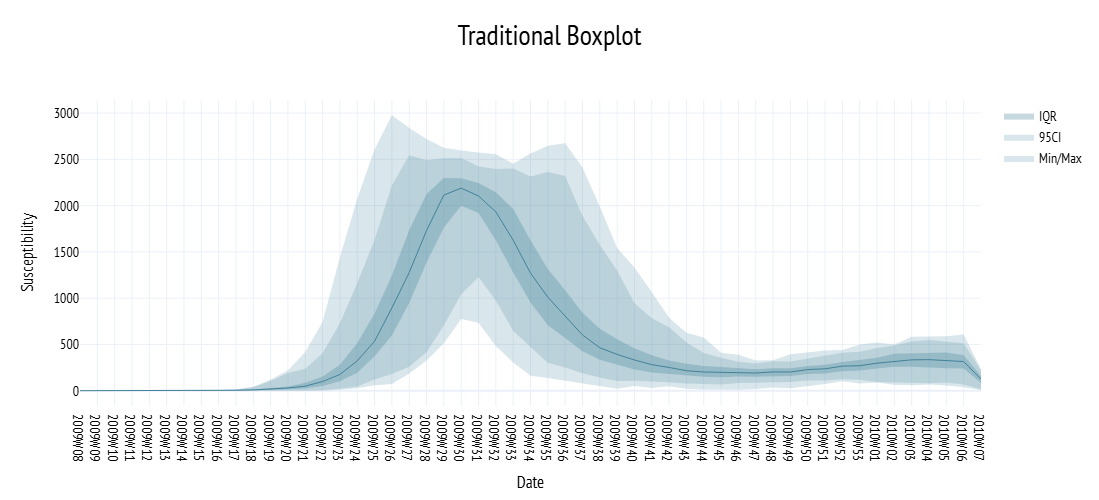

In [20]:
# required
table_name = 'h1n1_R2.basins_prevalence_agg'
reference_table = 'reference.gleam-geo-map'
reference_column = 'basin_id' # name of a column in reference table
geo_column = 'basin_id' # name of a column in table corresponding to column in reference table
geo_level = 'basin_label'
geo_values = 'Portland(US-ME)'
value = 'Infectious_18_23'

# Set parameters for grouping
num_clusters = 1
num_features = 20 
grouping_method = 'mse' # mean squared error
confidence = .95

dataset = None
delete_data = True

ft_fig = ei.fixed_time_boxplot(
    client,
    table_name,
    reference_table,
    geo_level,
    geo_values,
    geo_column=geo_column,
    reference_column=reference_column,
    num_clusters=num_clusters,
    num_features=num_features,
    grouping_method=grouping_method,
    value=value,
    dataset=dataset,
    delete_data=delete_data,
    kmeans_table=False,
    confidence=confidence,
    full_range=True,
    outlying_points=False,
)

# finishing touches
ft_fig.update_layout(width=900, height=500, 
                     showlegend=True, 
                     font_family='PT Sans Narrow', 
                     title='Traditional Boxplot',)
ft_fig.update_layout(showlegend=True)

## fetch_fixed_time_quantiles

Allows calculation of custom fixed-time quantiles. Always fetches median. 

### Parameters
`client` (`bigquery.Client`): BigQuery client object.

`table_name` (`str`): BigQuery table name containing data in 'dataset.table' form. 

`reference_table` (`str`): BigQuery table name containing reference table in 'dataset.table' form.

`confidences` (`list` of `float`): List of confidences to gather, from 0 to 1. For example, entering `.5` will result in the 25th and 75th percentiles being calculated. 

`geo_level` (`str`): The name of a column from the reference table. The geographical level used to determine what places are included. 

`geo_values` (`str` or `listlike` or `None`): The geographies to be included. A value or subset of values from the `geo_level` column. If None, then all values will be included. 

`geo_column` (`str`, optional): Name of column in original table containing geography identifier. Defaults to 'basin_id'.

`reference_column` (`str`, optional): Name of column in original table containing the geography corresponding to data in `source_column` and `target_column`. Defaults to 'basin_id'. 

`value` (`str`, optional): Name of column in the original table containing the importation value to be analyzed. Defaults to 'value'.

`num_clusters` (`int`, optional): Number of clusters that curves will be broken into based on `grouping_method`. Defaults to 1. *Note: raising `num_clusters` above one significantly increases runtime.*

`num_features` (`int`, optional): Number of features the kmeans algorithm will use to group curves if `num_clusters` in greater than 1. Must be less than or equal to number of run_ids in table. 

`grouping_method` (`str`, optional): Method used to group curves. Must be one of: 
- `'mse'` *(default)*: Fixed-time pairwise mean squared error between curves.

- `'abc'`: Fixed-time pairwise area between curves. Also called mean absolute error.  

`kmeans_table` (`str`, optional): BigQuery table name containing clustering information in 'dataset.table' form. Used when kmeans has already been performed with `delete_data=False`. Allows function to skip costly kmeans algorithm. 

`dataset` (`str` or `None`, optional): Name of BigQuery dataset to store intermediate tables. If `None`, then random hash value will be used. Defaults to `None`. 

`delete_data` (`bool`, optional): If True, then intermediate data tables will not be deleted. Defaults to False. 

`overwrite` (`bool`, optional): If True, then will not prompt for confirmation if overwriting an existing BigQuery dataset. Defaults to False. 

---
### Returns
`df` (`pandas.DataFrame`): pandas dataframe containing quantiles and median. 

---

### Example

In [21]:
# uses the same parameters as fixed_time_boxplot!
df_ft = ei.boxplots.fetch_fixed_time_quantiles(
    client=client,
    table_name=table_name,
    reference_table=reference_table,
    confidences=[.9, .5], # just introduce the confidences parameter
    geo_level=geo_level,
    geo_values=geo_values,
    geo_column=geo_column,
    reference_column=reference_column,
    num_clusters=num_clusters,
    num_features=num_features,
    grouping_method=grouping_method,
    value=value,
    dataset=dataset,
    delete_data=delete_data,
    kmeans_table=False,
)

df_ft

Dataset `net-data-viz-handbook.ab7c684e00be1a0a79bf20da8828ed72fe66bf1ce58fb99fd4ba1a06a0ade3aa` created.


BadRequest: 400 Unrecognized name: DISINCT at [11:16]; reason: invalidQuery, location: query, message: Unrecognized name: DISINCT at [11:16]

Location: US
Job ID: 53cab13b-8c0f-4960-affe-9c835ea20513
